In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings("ignore")

## Data Load

In [26]:
ori = np.load('../Data-Driven Analysis/Result/DDPM + Gaussian/generate_data_unnorm_toyexample.npy')
gen = np.load('../Data-Driven Analysis/Result/DDPM + Student-t/generate_data_unnorm_toyexample.npy')

In [3]:
def split_to_chunks(data, seq_length):
    """
    data: np.ndarray, shape (M, C)
    return: np.ndarray, shape (N, seq_length, C)
    """
    M, C = data.shape
    num_chunks = M // seq_length
    trimmed = data[: num_chunks * seq_length]
    chunks = trimmed.reshape(num_chunks, seq_length, C)
    return chunks

## Distribution Visualization

In [4]:
def visualization_distribution(ori_data, generated_data):
    """PCA / tSNE / KDE visualization in a 3x3 grid:
       Col1: Original, Col2: Synthetic, Col3: Overlay (Original + Synthetic)
    """

    ori_data = np.asarray(ori_data)
    generated_data = np.asarray(generated_data)

    no, seq_len, dim = ori_data.shape

    # (no, seq_len): each sample -> mean over feature dim
    # 原来你的写法是循环拼接，这里等价向量化（更快、更简洁）
    prep_data = np.mean(ori_data, axis=2)        # (no, seq_len)
    prep_data_hat = np.mean(generated_data, axis=2)

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    titles = ["Original", "Synthetic", "Overlay"]

    # ===================== Row 1: PCA =====================
    pca = PCA(n_components=2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)

    # Original
    axes[0, 0].scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.2, s=10)
    axes[0, 0].set_title(f"PCA | {titles[0]}")
    axes[0, 0].set_xlabel("x-pca")
    axes[0, 0].set_ylabel("y-pca")

    # Synthetic
    axes[0, 1].scatter(pca_hat_results[:, 0], pca_hat_results[:, 1], alpha=0.2, s=10)
    axes[0, 1].set_title(f"PCA | {titles[1]}")
    axes[0, 1].set_xlabel("x-pca")
    axes[0, 1].set_ylabel("y-pca")

    # Overlay
    axes[0, 2].scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.2, s=10, label="Original")
    axes[0, 2].scatter(pca_hat_results[:, 0], pca_hat_results[:, 1], alpha=0.2, s=10, label="Synthetic")
    axes[0, 2].set_title(f"PCA | {titles[2]}")
    axes[0, 2].set_xlabel("x-pca")
    axes[0, 2].set_ylabel("y-pca")
    axes[0, 2].legend(frameon=False)

    # ===================== Row 2: t-SNE =====================
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

    # sklearn 有的版本是 n_iter，有的版本是 max_iter；你原来用 n_iter，这里保持不动
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(prep_data_final)

    tsne_ori = tsne_results[:no]
    tsne_hat = tsne_results[no:]

    # Original
    axes[1, 0].scatter(tsne_ori[:, 0], tsne_ori[:, 1], alpha=0.2, s=10)
    axes[1, 0].set_title(f"t-SNE | {titles[0]}")
    axes[1, 0].set_xlabel("x-tsne")
    axes[1, 0].set_ylabel("y-tsne")

    # Synthetic
    axes[1, 1].scatter(tsne_hat[:, 0], tsne_hat[:, 1], alpha=0.2, s=10)
    axes[1, 1].set_title(f"t-SNE | {titles[1]}")
    axes[1, 1].set_xlabel("x-tsne")
    axes[1, 1].set_ylabel("y-tsne")

    # Overlay
    axes[1, 2].scatter(tsne_ori[:, 0], tsne_ori[:, 1], alpha=0.2, s=10, label="Original")
    axes[1, 2].scatter(tsne_hat[:, 0], tsne_hat[:, 1], alpha=0.2, s=10, label="Synthetic")
    axes[1, 2].set_title(f"t-SNE | {titles[2]}")
    axes[1, 2].set_xlabel("x-tsne")
    axes[1, 2].set_ylabel("y-tsne")
    axes[1, 2].legend(frameon=False)

    # ===================== Row 3: KDE =====================
    flat_ori = prep_data.reshape(-1)
    flat_hat = prep_data_hat.reshape(-1)

    # Original
    sns.kdeplot(flat_ori, linewidth=3, ax=axes[2, 0])
    axes[2, 0].set_title(f"KDE | {titles[0]}")
    axes[2, 0].set_xlabel("Data Value")
    axes[2, 0].set_ylabel("Density")

    # Synthetic
    sns.kdeplot(flat_hat, linewidth=3, linestyle="--", ax=axes[2, 1])
    axes[2, 1].set_title(f"KDE | {titles[1]}")
    axes[2, 1].set_xlabel("Data Value")
    axes[2, 1].set_ylabel("Density")

    # Overlay
    sns.kdeplot(flat_ori, linewidth=3, ax=axes[2, 2], label="Original")
    sns.kdeplot(flat_hat, linewidth=3, linestyle="--", ax=axes[2, 2], label="Synthetic")
    axes[2, 2].set_title(f"KDE | {titles[2]}")
    axes[2, 2].set_xlabel("Data Value")
    axes[2, 2].set_ylabel("Density")
    axes[2, 2].legend(frameon=False)

    plt.tight_layout()
    plt.show()
    plt.close()


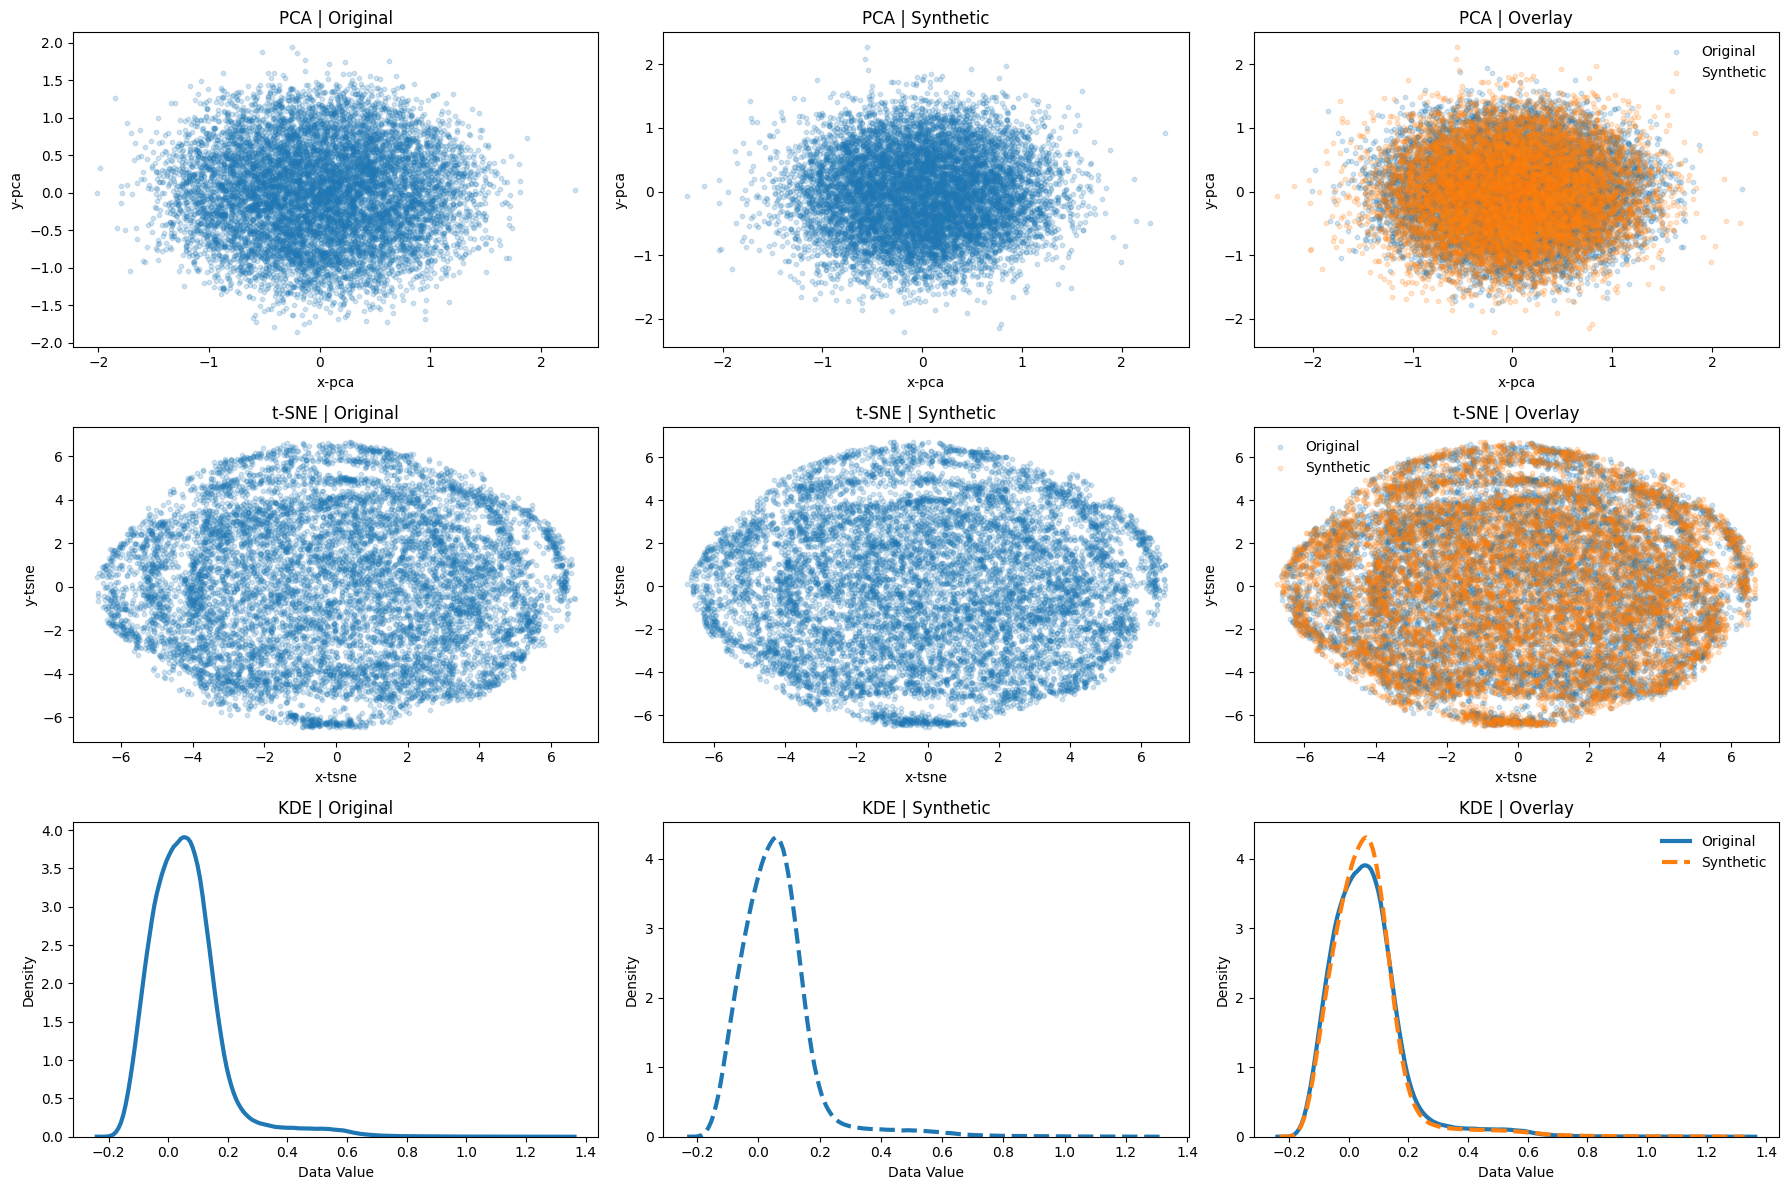

In [5]:
visualization_distribution(ori, gen)

## Sample Visualization and Analysis

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_sample(origin_data, generated_data, num=8, channel=0,
                y_pad_ratio=0.05, n_yticks=6,
                u_global=None, u_label="u_global",
                mark_extremes=False,
                seed=None):
    """
    origin_data:    (N, T, C)
    generated_data: (N, T, C)
    num:            抽样条数（默认 8）
    channel:        可视化的特征维（默认 0）
    y_pad_ratio:    y 轴上下留白比例
    n_yticks:       y 轴刻度数量（两张图一致）
    u_global:       全局阈值线（标量）。超过该线视为极值
    u_label:        阈值线图例文本
    mark_extremes:  是否把超过阈值的点用散点标出来（可选）
    seed:           随机种子；None 表示每次调用都不同
    """
    origin_data = np.asarray(origin_data)
    generated_data = np.asarray(generated_data)

    N1, T1, C1 = origin_data.shape
    N2, T2, C2 = generated_data.shape

    if (T1 != T2) or (C1 != C2):
        raise ValueError(f"Shape mismatch: origin={origin_data.shape}, generated={generated_data.shape}")

    N = min(N1, N2)
    num = min(num, N)

    # 有 seed -> 可复现；无 seed -> 每次不同
    rng = np.random.default_rng(seed)
    idx = rng.choice(N, size=num, replace=False)

    x = np.arange(T1)

    y_all = np.concatenate([
        origin_data[idx, :, channel].reshape(-1),
        generated_data[idx, :, channel].reshape(-1)
    ], axis=0)

    if u_global is not None:
        u_global = float(u_global)
        y_all = np.concatenate([y_all, np.array([u_global], dtype=y_all.dtype)], axis=0)

    y_min = float(np.min(y_all))
    y_max = float(np.max(y_all))

    span = y_max - y_min
    if span < 1e-12:
        span = 1.0
    pad = span * y_pad_ratio
    y_min -= pad
    y_max += pad

    locator = MaxNLocator(nbins=n_yticks)

    def _add_threshold_line(ax):
        if u_global is None:
            return
        ax.axhline(u_global, linestyle="--", linewidth=1.5, label=u_label)

    def _mark_extreme_points(ax, y):
        if (u_global is None) or (not mark_extremes):
            return
        mask = (y > u_global)
        if np.any(mask):
            ax.scatter(x[mask], y[mask], s=14, marker="o", zorder=3)

    # -------- Figure 1: Origin --------
    fig1, ax1 = plt.subplots(figsize=(10, 4))
    num1 = 1
    for i in idx:
        y = origin_data[i, :, channel]
        ax1.plot(x, y, alpha=0.9, label=f"idx={num1}")
        _mark_extreme_points(ax1, y)
        num1 += 1

    _add_threshold_line(ax1)

    ax1.set_title(f"Random {num} samples | Origin (channel={channel})")
    ax1.set_xlabel("Time index")
    ax1.set_ylabel("Value")
    ax1.set_ylim(y_min, y_max)
    ax1.yaxis.set_major_locator(locator)
    ax1.legend(loc="upper left",ncol=5)
    fig1.tight_layout()
    plt.show()

    # -------- Figure 2: Generated --------
    fig2, ax2 = plt.subplots(figsize=(10, 4))
    num2 = 1
    for i in idx:
        y = generated_data[i, :, channel]
        ax2.plot(x, y, alpha=0.9, label=f"idx={num2}")
        _mark_extreme_points(ax2, y)
        num2 += 1

    _add_threshold_line(ax2)

    ax2.set_title(f"Random {num} samples | Generated (channel={channel})")
    ax2.set_xlabel("Time index")
    ax2.set_ylabel("Value")
    ax2.set_ylim(y_min, y_max)
    ax2.yaxis.set_major_locator(locator)
    ax2.legend(loc="upper left",ncol=5)
    fig2.tight_layout()
    plt.show()

    return idx


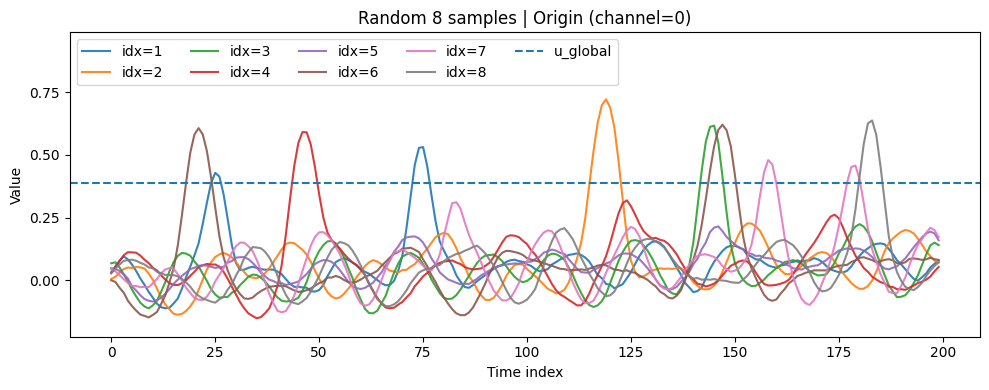

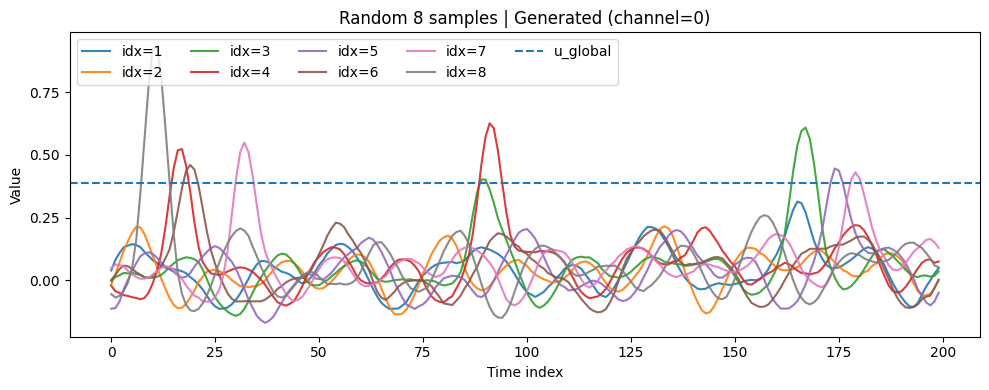

[ 859 6973 8584 6542 4328 4387  891 7734]


In [7]:
u_global = 0.3880803084373474
idx = plot_sample(ori, gen, u_global=u_global, num=8, channel=0, seed = 42)
print(idx)

### Overall Visualization and Analysis

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_overall_dist(origin_data, generated_data, bins=80, density=True,
                      clip_percentile=None, legend_loc="upper left",
                      xlim=(-0.5, 1.5)):
    ori = np.asarray(origin_data)
    gen = np.asarray(generated_data)

    if ori.ndim == 3: ori = ori[..., 0]
    if gen.ndim == 3: gen = gen[..., 0]
    if ori.shape != gen.shape:
        raise ValueError(f"Shape mismatch: ori={ori.shape}, gen={gen.shape}")

    ori_flat = ori.reshape(-1)
    gen_flat = gen.reshape(-1)

    if clip_percentile is not None and clip_percentile > 0:
        p = float(clip_percentile)
        lo = np.percentile(np.concatenate([ori_flat, gen_flat]), p)
        hi = np.percentile(np.concatenate([ori_flat, gen_flat]), 100 - p)
        ori_flat = np.clip(ori_flat, lo, hi)
        gen_flat = np.clip(gen_flat, lo, hi)

    # 关键：统一 bin edges（用共同范围）
    all_flat = np.concatenate([ori_flat, gen_flat])
    if xlim is None:
        lo, hi = float(all_flat.min()), float(all_flat.max())
    else:
        lo, hi = float(xlim[0]), float(xlim[1])
    edges = np.linspace(lo, hi, int(bins) + 1)

    plt.figure(figsize=(8, 4))
    plt.hist(ori_flat, bins=edges, density=density, alpha=0.5, label="Origin")
    plt.hist(gen_flat, bins=edges, density=density, alpha=0.5, label="Generated")
    plt.title(f"Overall Distribution (flattened N*T={ori_flat.size})")
    plt.xlabel("Value")
    plt.ylabel("Density" if density else "Count")
    if xlim is not None:
        plt.xlim(*xlim)
    plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

    return {
        "origin_mean": float(np.mean(ori_flat)),
        "origin_std": float(np.std(ori_flat)),
        "gen_mean": float(np.mean(gen_flat)),
        "gen_std": float(np.std(gen_flat)),
    }


def plot_topk_tail_dist(origin_data, generated_data, k=10000, bins=80,
                        logy=True, legend_loc="upper left",
                        mark_u=True, base_ticks=(0.5, 1.0, 1.5, 2.0),
                        xlim=None):
    ori = np.asarray(origin_data)
    gen = np.asarray(generated_data)

    if ori.ndim == 3: ori = ori[..., 0]
    if gen.ndim == 3: gen = gen[..., 0]
    if ori.shape != gen.shape:
        raise ValueError(f"Shape mismatch: ori={ori.shape}, gen={gen.shape}")

    ori_flat = ori.reshape(-1)
    gen_flat = gen.reshape(-1)

    k = int(min(k, ori_flat.size, gen_flat.size))
    if k <= 0:
        raise ValueError("k must be positive.")

    ori_topk = np.partition(ori_flat, -k)[-k:]
    gen_topk = np.partition(gen_flat, -k)[-k:]

    u_ori = float(np.min(ori_topk))
    u_gen = float(np.min(gen_topk))

    # ✅ 关键：对齐 bins（用 topk 合并后的范围）
    all_topk = np.concatenate([ori_topk, gen_topk])
    if xlim is None:
        lo, hi = float(all_topk.min()), float(all_topk.max())
    else:
        lo, hi = float(xlim[0]), float(xlim[1])
    edges = np.linspace(lo, hi, int(bins) + 1)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(ori_topk, bins=edges, density=False, alpha=0.5, label=f"Origin top-{k}")
    ax.hist(gen_topk, bins=edges, density=False, alpha=0.5, label=f"Generated top-{k}")

    if logy:
        ax.set_yscale("log")

    if mark_u:
        ax.axvline(u_ori, linestyle="--", linewidth=1.5, label=f"u_ori={u_ori:.4g}")
        ax.axvline(u_gen, linestyle=":",  linewidth=1.8, label=f"u_gen={u_gen:.4g}")

    # xticks 把 u 标上去（不 round 更准确；但担心太密可自行 round）
    ticks = sorted(set(list(base_ticks) + [u_ori, u_gen]))
    ax.set_xticks(ticks)

    ax.set_title(f"Tail distribution using top-{k} points (Count)")
    ax.set_xlabel("Value (tail)")
    ax.set_ylabel("Count")
    ax.legend(loc=legend_loc)
    fig.tight_layout()
    plt.show()

    return {
        "k": k,
        "origin_topk": ori_topk,
        "gen_topk": gen_topk,
        "u_origin": u_ori,
        "u_gen": u_gen,
        "bin_edges": edges,
    }

def plot_tail_above_u(origin_data, generated_data, u,
                      bins=80, logy=True,
                      legend_loc="upper left",
                      base_ticks=(0.5, 1.0, 1.5, 2.0),
                      xlim=None):
    ori = np.asarray(origin_data)
    gen = np.asarray(generated_data)

    if ori.ndim == 3: ori = ori[..., 0]
    if gen.ndim == 3: gen = gen[..., 0]
    if ori.shape != gen.shape:
        raise ValueError(f"Shape mismatch: ori={ori.shape}, gen={gen.shape}")

    ori_flat = ori.reshape(-1)
    gen_flat = gen.reshape(-1)
    u = float(u)

    ori_tail = ori_flat[ori_flat > u]
    gen_tail = gen_flat[gen_flat > u]

    # ✅ 关键：对齐 bins（用 exceedances 合并后的范围）
    all_tail = np.concatenate([
        ori_tail if ori_tail.size else np.array([u], dtype=np.float32),
        gen_tail if gen_tail.size else np.array([u], dtype=np.float32),
    ])

    if xlim is None:
        lo, hi = float(all_tail.min()), float(all_tail.max())
        # 保证左边界不小于 u（因为我们只画 x>u）
        lo = max(lo, u)
    else:
        lo, hi = float(xlim[0]), float(xlim[1])

    if abs(hi - lo) < 1e-12:
        hi = lo + 1.0

    edges = np.linspace(lo, hi, int(bins) + 1)

    plt.figure(figsize=(8, 4))
    if ori_tail.size > 0:
        plt.hist(ori_tail, bins=edges, density=False, alpha=0.5,
                 label=f"Origin (x>u): {ori_tail.size}")
    if gen_tail.size > 0:
        plt.hist(gen_tail, bins=edges, density=False, alpha=0.5,
                 label=f"Generated (x>u): {gen_tail.size}")

    if logy:
        plt.yscale("log")

    plt.title(f"Tail distribution above threshold (u={u:.4g}) (Count)")
    plt.xlabel("Value (x | x > u)")
    plt.ylabel("Count")
    ticks = sorted(set(list(base_ticks) + [u]))
    plt.xticks(ticks)
    plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

    return {
        "u": u,
        "origin_count": int(ori_tail.size),
        "gen_count": int(gen_tail.size),
        "origin_tail": ori_tail,
        "gen_tail": gen_tail,
        "bin_edges": edges,
    }


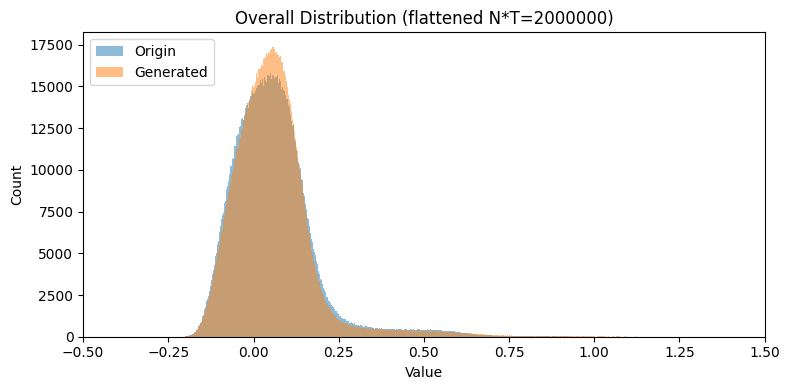

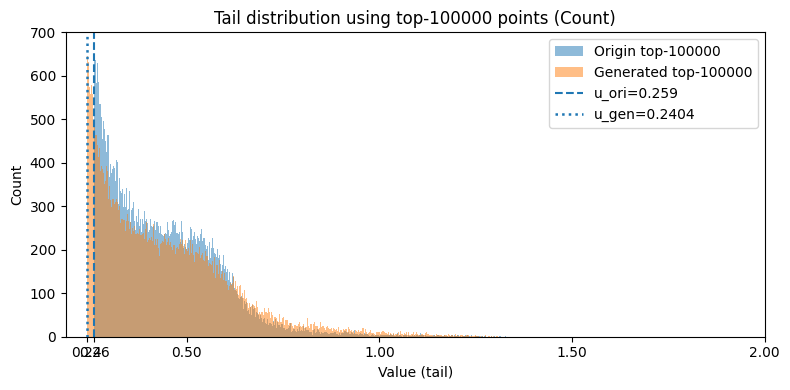

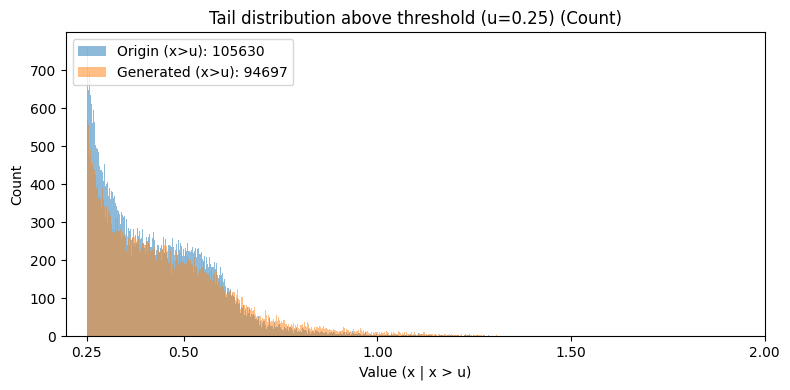

In [9]:
stats1 = plot_overall_dist(ori, gen, bins=1000, density = False)
stats2 = plot_topk_tail_dist(ori, gen, k=100000, bins=1000, logy=False,  legend_loc = 'upper right')
stats3 = plot_tail_above_u(ori, gen, u=0.25, bins=1000, logy=False)

In [10]:
# general trend season distribution

In [11]:
import numpy as np
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt

def plot_trend_global_params_count(
    origin_data, generated_data,
    u_global,
    season_ks=(5, 8, 11),
    bins=80,
    logy=False,
    legend_loc="upper left",
    # 关键：剔除 exceedance 附近的半径（建议用 ceil(3*sigma)，例如 sigma=2.5 -> radius=8）
    event_radius=8,
    min_keep_ratio=0.6,
):
    def _to_2d(X):
        X = np.asarray(X)
        if X.ndim == 3:
            X = X[..., 0]
        return X  # (N,T)

    def _dilate_hits_1d(hits, radius):
        """hits: (T,) bool, return: (T,) bool after dilation by +-radius"""
        hits = hits.astype(np.int32)
        if radius <= 0:
            return hits.astype(bool)
        win = 2 * int(radius) + 1
        kernel = np.ones(win, dtype=np.int32)
        # same: length T
        dil = np.convolve(hits, kernel, mode="same")
        return (dil > 0)

    def _fit_known_season(x, t, ks, keep_mask):
        if ks is None or len(ks) == 0:
            return np.zeros_like(x, dtype=np.float32)

        T = float(len(t))
        cols = []
        for k in ks:
            w = 2.0 * np.pi * float(k) * t / T
            cols.append(np.sin(w))
            cols.append(np.cos(w))
        A = np.stack(cols, axis=1).astype(np.float32)  # (T, 2K)

        idx = np.where(keep_mask)[0]
        if idx.size < int(min_keep_ratio * len(t)):
            idx = np.arange(len(t))  # 兜底：避免不可解

        coef, *_ = np.linalg.lstsq(A[idx], x[idx], rcond=None)
        return (A @ coef).astype(np.float32)

    def _fit_trend_start_rise(x_deseason, t_norm, keep_mask):
        idx = np.where(keep_mask)[0]
        if idx.size < int(min_keep_ratio * len(t_norm)):
            idx = np.arange(len(t_norm))

        Xmat = np.stack([np.ones_like(t_norm), t_norm], axis=1).astype(np.float32)  # (T,2)
        beta, *_ = np.linalg.lstsq(Xmat[idx], x_deseason[idx], rcond=None)
        start = float(beta[0])
        rise  = float(beta[1])   # t_norm∈[0,1]，所以 beta[1] 就是整段 rise
        return start, rise, idx.size / len(t_norm)

    ori = _to_2d(origin_data)
    gen = _to_2d(generated_data)
    if ori.shape != gen.shape:
        raise ValueError(f"Shape mismatch: ori={ori.shape}, gen={gen.shape}")

    N, T = ori.shape
    t = np.arange(T, dtype=np.float32)
    t_norm = t / float(T - 1)
    u_global = float(u_global)

    ori_start = np.zeros((N,), dtype=np.float32)
    ori_rise  = np.zeros((N,), dtype=np.float32)
    gen_start = np.zeros((N,), dtype=np.float32)
    gen_rise  = np.zeros((N,), dtype=np.float32)
    keep_ratio_ori = np.zeros((N,), dtype=np.float32)
    keep_ratio_gen = np.zeros((N,), dtype=np.float32)

    for i in range(N):
        # -------- Origin --------
        x = ori[i].astype(np.float32)
        hits = (x > u_global)                       # exceedance
        event_region = _dilate_hits_1d(hits, event_radius)
        keep = ~event_region                         # 剔除 exceedance 邻域（包含阈值点 + 尾巴邻域）

        season_hat = _fit_known_season(x, t, season_ks, keep)
        x_deseason = x - season_hat
        s0, r0, kr0 = _fit_trend_start_rise(x_deseason, t_norm, keep)
        ori_start[i], ori_rise[i], keep_ratio_ori[i] = s0, r0, kr0

        # -------- Generated --------
        xg = gen[i].astype(np.float32)
        hitsg = (xg > u_global)
        event_region_g = _dilate_hits_1d(hitsg, event_radius)
        keepg = ~event_region_g

        season_hat_g = _fit_known_season(xg, t, season_ks, keepg)
        xg_deseason = xg - season_hat_g
        s1, r1, kr1 = _fit_trend_start_rise(xg_deseason, t_norm, keepg)
        gen_start[i], gen_rise[i], keep_ratio_gen[i] = s1, r1, kr1

    # ====== 画 rise/start（Count + bins 对齐）======
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    r_all = np.concatenate([ori_rise, gen_rise])
    r_min, r_max = float(r_all.min()), float(r_all.max())
    if abs(r_max - r_min) < 1e-12:
        r_min, r_max = r_min - 1.0, r_max + 1.0
    r_edges = np.linspace(r_min, r_max, int(bins) + 1)

    axes[0].hist(ori_rise, bins=r_edges, density=False, alpha=0.5, label="Origin")
    axes[0].hist(gen_rise, bins=r_edges, density=False, alpha=0.5, label="Generated")
    if logy: axes[0].set_yscale("log")
    axes[0].set_title("Trend rise (Count)")
    axes[0].set_xlabel("rise (≈ a in generator)")
    axes[0].set_ylabel("Count")
    #axes[0].set_xlim(-0.05,0.15)
    axes[0].legend(loc=legend_loc)

    s_all = np.concatenate([ori_start, gen_start])
    s_min, s_max = float(s_all.min()), float(s_all.max())
    if abs(s_max - s_min) < 1e-12:
        s_min, s_max = s_min - 1.0, s_max + 1.0
    s_edges = np.linspace(s_min, s_max, int(bins) + 1)

    axes[1].hist(ori_start, bins=s_edges, density=False, alpha=0.5, label="Origin")
    axes[1].hist(gen_start, bins=s_edges, density=False, alpha=0.5, label="Generated")
    if logy: axes[1].set_yscale("log")
    axes[1].set_title("Trend start (Count)")
    axes[1].set_xlabel("start (≈ b0 in generator)")
    axes[1].set_ylabel("Count")
    #axes[1].set_xlim(-0.05,0.05)
    axes[1].legend(loc=legend_loc)

    fig.tight_layout()
    plt.show()

    print(f"[keep_ratio] origin mean={keep_ratio_ori.mean():.3f}, gen mean={keep_ratio_gen.mean():.3f}")

    return {
        "u_global": u_global,
        "season_ks": tuple(season_ks),
        "event_radius": int(event_radius),
        "origin_rise": ori_rise,
        "gen_rise": gen_rise,
        "origin_start": ori_start,
        "gen_start": gen_start,
        "keep_ratio_origin": keep_ratio_ori,
        "keep_ratio_gen": keep_ratio_gen,
        "rise_bin_edges": r_edges,
        "start_bin_edges": s_edges,
    }

def plot_k_energy_count(origin_data, generated_data,
                                         ks=(5, 8, 11),
                                         bins=80,
                                         logy=True,
                                         band=1):
    """
    不去 trend，直接在 x-mean 上做 rFFT，取指定频点能量分布。
    - ks: 频点索引（对应你生成器的 season_bins）
    - band: 0 表示只取 spec[k]，1 表示 spec[k-1:k+1] 求和（推荐）
    - count（density=False），bins 对齐
    """
    def _to_2d(X):
        X = np.asarray(X)
        if X.ndim == 3:
            X = X[..., 0]
        return X  # (N,T)

    def _power_spectrum(x):
        x = np.asarray(x, dtype=np.float32).reshape(-1)
        xc = x - x.mean()  # 只去均值
        spec = np.abs(np.fft.rfft(xc))**2
        spec[0] = 0.0
        return spec

    def _band_energy(spec, k, band):
        k = int(k)
        lo = max(1, k - int(band))
        hi = min(spec.shape[0] - 1, k + int(band))
        return float(np.sum(spec[lo:hi+1]))

    ori = _to_2d(origin_data)
    gen = _to_2d(generated_data)
    if ori.shape != gen.shape:
        raise ValueError(f"Shape mismatch: ori={ori.shape}, gen={gen.shape}")

    N, T = ori.shape
    ks = [int(k) for k in ks]
    max_k = T // 2
    for k in ks:
        if k <= 0 or k > max_k:
            raise ValueError(f"k={k} invalid for T={T}, valid 1..{max_k}")

    E_ori = {k: np.zeros((N,), dtype=np.float32) for k in ks}
    E_gen = {k: np.zeros((N,), dtype=np.float32) for k in ks}

    for i in range(N):
        spec0 = _power_spectrum(ori[i])
        spec1 = _power_spectrum(gen[i])
        for k in ks:
            E_ori[k][i] = _band_energy(spec0, k, band)
            E_gen[k][i] = _band_energy(spec1, k, band)

    fig, axes = plt.subplots(1, len(ks), figsize=(4 * len(ks), 4))
    if len(ks) == 1:
        axes = [axes]

    bin_edges = {}
    for ax, k in zip(axes, ks):
        e1, e2 = E_ori[k], E_gen[k]
        e_all = np.concatenate([e1, e2])
        e_min, e_max = float(e_all.min()), float(e_all.max())
        if abs(e_max - e_min) < 1e-12:
            e_min, e_max = 0.0, e_min + 1.0
        edges = np.linspace(e_min, e_max, int(bins) + 1)
        bin_edges[k] = edges

        ax.hist(e1, bins=edges, density=False, alpha=0.5, label="Origin")
        ax.hist(e2, bins=edges, density=False, alpha=0.5, label="Generated")
        if logy:
            ax.set_yscale("log")

        p = T / k
        ax.set_title(f"Energy at k={k}")
        ax.set_xlabel("sum |FFT|^2 around k" if band > 0 else "|FFT[k]|^2")
        ax.set_ylabel("Count")
        ax.legend(loc="upper left")

    fig.tight_layout()
    plt.show()

    return {
        "ks": tuple(ks),
        "band": int(band),
        "E_origin": E_ori,
        "E_gen": E_gen,
        "bin_edges": bin_edges,
    }

def plot_mean_spectrum_bars(origin_data, generated_data,
                            k_max=50,
                            fs=1.0,
                            use_power=True,     # True: |FFT|^2, False: |FFT|
                            remove_dc=True,
                            detrend=None,       # None or "linear"
                            logy=False,
                            bar_width=0.4,
                            legend_loc="upper right"):
    """
    平均频谱（柱状图，ori vs gen）：
      - 每条序列 rFFT -> |FFT| 或 |FFT|^2
      - 在每个频点上对 N 条序列取平均
      - 只画频点 k=0..k_max（k_max<=T//2）
      - ori/gen 并排柱状图
    """
    def _to_2d(X):
        X = np.asarray(X)
        if X.ndim == 3:
            X = X[..., 0]
        return X  # (N,T)

    def _linear_detrend(x):
        x = np.asarray(x, dtype=np.float32).reshape(-1)
        T = x.shape[0]
        t_norm = np.arange(T, dtype=np.float32) / float(T - 1)
        Xmat = np.stack([np.ones_like(t_norm), t_norm], axis=1).astype(np.float32)
        beta, *_ = np.linalg.lstsq(Xmat, x, rcond=None)
        trend_hat = Xmat @ beta
        return (x - trend_hat).astype(np.float32)

    def _spec_1d(x):
        x = np.asarray(x, dtype=np.float32).reshape(-1)
        if detrend == "linear":
            x = _linear_detrend(x)
        xc = x - x.mean()
        F = np.fft.rfft(xc)
        mag = np.abs(F)
        spec = mag**2 if use_power else mag
        if remove_dc:
            spec[0] = 0.0
        return spec.astype(np.float32)

    ori = _to_2d(origin_data)
    gen = _to_2d(generated_data)
    if ori.shape != gen.shape:
        raise ValueError(f"Shape mismatch: ori={ori.shape}, gen={gen.shape}")

    N, T = ori.shape
    K = T // 2 + 1
    k_max = int(min(k_max, K - 1))

    specs_ori = np.empty((N, K), dtype=np.float32)
    specs_gen = np.empty((N, K), dtype=np.float32)
    for i in range(N):
        specs_ori[i] = _spec_1d(ori[i])
        specs_gen[i] = _spec_1d(gen[i])

    mean_ori = specs_ori.mean(axis=0)[:k_max+1]
    mean_gen = specs_gen.mean(axis=0)[:k_max+1]

    ks = np.arange(k_max + 1)
    x = ks  # 横轴用 frequency bin k；如果你想用频率，可改成 rfftfreq

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(x - bar_width/2, mean_ori, width=bar_width, label="Origin (mean)")
    ax.bar(x + bar_width/2, mean_gen, width=bar_width, label="Generated (mean)")

    if logy:
        ax.set_yscale("log")

    yname = "Mean Power |FFT|^2" if use_power else "Mean Amplitude |FFT|"
    title = f"Mean spectrum (absolute)"
    if detrend == "linear":
        title += " | linear detrend"
    else:
        title += " | no detrend"

    ax.set_title(title)
    ax.set_xlabel("Frequency bin k")
    ax.set_ylabel(yname)
    ax.set_xticks(np.arange(0, k_max + 1, 5))
    ax.legend(loc=legend_loc)
    fig.tight_layout()
    plt.show()

    return {
        "T": int(T),
        "K": int(K),
        "k_max": int(k_max),
        "mean_origin": mean_ori,
        "mean_generated": mean_gen,
        "bins_k": ks,
        "freqs": np.fft.rfftfreq(T, d=1.0 / float(fs))[:k_max+1],
    }

def plot_spectrum(origin_data, generated_data,
                             k_max=50,
                             fs=1.0,
                             use_power=True,
                             remove_dc=True,
                             detrend=None,        # None or "linear"
                             logy_abs=False,
                             logy_norm=False,
                             legend_loc="upper right",
                             norm_mode="sum",
                             main_ks=(5, 8, 11),
                             main_title="Main vs Non-main frequency energy share"):
    """
    三张图：
      (A) absolute mean spectrum（折线）
      (B) normalized mean spectrum（折线）
      (C) 固定主流频率 main_ks 的能量占比 vs 非主流（柱状图）

    main_ks: tuple/list of frequency bins k (e.g., (5,8,11))
    说明：占比基于 mean spectrum 的绝对能量（k=1..k_max 的总和为分母）
    """

    def _to_2d(X):
        X = np.asarray(X)
        if X.ndim == 3:
            X = X[..., 0]
        return X  # (N,T)

    def _linear_detrend(x):
        x = np.asarray(x, dtype=np.float32).reshape(-1)
        T = x.shape[0]
        t_norm = np.arange(T, dtype=np.float32) / float(T - 1)
        Xmat = np.stack([np.ones_like(t_norm), t_norm], axis=1).astype(np.float32)
        beta, *_ = np.linalg.lstsq(Xmat, x, rcond=None)
        trend_hat = Xmat @ beta
        return (x - trend_hat).astype(np.float32)

    def _spec_1d(x):
        x = np.asarray(x, dtype=np.float32).reshape(-1)
        if detrend == "linear":
            x = _linear_detrend(x)
        xc = x - x.mean()
        F = np.fft.rfft(xc)
        mag = np.abs(F)
        spec = mag**2 if use_power else mag
        if remove_dc:
            spec[0] = 0.0
        return spec.astype(np.float32)

    ori = _to_2d(origin_data)
    gen = _to_2d(generated_data)
    if ori.shape != gen.shape:
        raise ValueError(f"Shape mismatch: ori={ori.shape}, gen={gen.shape}")

    N, T = ori.shape
    K = T // 2 + 1
    k_max = int(min(k_max, K - 1))

    specs_ori = np.empty((N, K), dtype=np.float32)
    specs_gen = np.empty((N, K), dtype=np.float32)
    for i in range(N):
        specs_ori[i] = _spec_1d(ori[i])
        specs_gen[i] = _spec_1d(gen[i])

    mean_ori = specs_ori.mean(axis=0)[:k_max+1]
    mean_gen = specs_gen.mean(axis=0)[:k_max+1]
    ks = np.arange(k_max + 1)

    # -------- (A) absolute lines --------
    fig1, ax1 = plt.subplots(figsize=(10, 4))
    ax1.plot(ks, mean_ori, label="Origin (mean)")
    ax1.plot(ks, mean_gen, label="Generated (mean)")
    if logy_abs:
        ax1.set_yscale("log")
    yname = "Mean Power |FFT|^2" if use_power else "Mean Amplitude |FFT|"
    ax1.set_title("Mean spectrum (absolute)")
    ax1.set_xlabel("Frequency bin k")
    ax1.set_ylabel(yname)
    ax1.set_xticks(np.arange(0, k_max + 1, 5))
    ax1.legend(loc=legend_loc)
    fig1.tight_layout()
    plt.show()

    # -------- (B) normalized lines --------
    eps = 1e-12
    if norm_mode == "sum":
        denom_ori = float(np.sum(mean_ori[1:]) + eps)
        denom_gen = float(np.sum(mean_gen[1:]) + eps)
        norm_ori = mean_ori / denom_ori
        norm_gen = mean_gen / denom_gen
        ylab = "Relative share (sum=1 over k>=1)"
    elif norm_mode == "max":
        denom_ori = float(np.max(mean_ori[1:]) + eps)
        denom_gen = float(np.max(mean_gen[1:]) + eps)
        norm_ori = mean_ori / denom_ori
        norm_gen = mean_gen / denom_gen
        ylab = "Relative value (max=1 over k>=1)"
    else:
        raise ValueError("norm_mode must be 'sum' or 'max'")

    fig2, ax2 = plt.subplots(figsize=(10, 4))
    ax2.plot(ks, norm_ori, label="Origin (normalized)")
    ax2.plot(ks, norm_gen, label="Generated (normalized)")
    if logy_norm:
        ax2.set_yscale("log")
    ax2.set_title(f"Mean spectrum (normalized: {norm_mode})")
    ax2.set_xlabel("Frequency bin k")
    ax2.set_ylabel(ylab)
    ax2.set_xticks(np.arange(0, k_max + 1, 5))
    ax2.legend(loc=legend_loc)
    fig2.tight_layout()
    plt.show()

    # -------- (C) fixed main vs non-main shares (bars) --------
    main_ks = [int(k) for k in main_ks]
    main_ks = [k for k in main_ks if (1 <= k <= k_max)]
    if len(main_ks) == 0:
        raise ValueError(f"main_ks has no valid k within [1, {k_max}]")

    total_ori = float(np.sum(mean_ori[1:]) + eps)
    total_gen = float(np.sum(mean_gen[1:]) + eps)

    main_ori = float(np.sum(mean_ori[main_ks]) / total_ori)
    nonmain_ori = 1.0 - main_ori
    main_gen = float(np.sum(mean_gen[main_ks]) / total_gen)
    nonmain_gen = 1.0 - main_gen

    fig3, ax3 = plt.subplots(figsize=(7, 4))
    xcats = np.array([0, 1], dtype=np.float32)  # 0=main, 1=non-main

    w = 0.25  # 瘦一点（原来 0.35）
    x_ori = xcats - w/2
    x_gen = xcats + w/2

    bars_ori = ax3.bar(x_ori, [main_ori, nonmain_ori], width=w, label="Origin")
    bars_gen = ax3.bar(x_gen, [main_gen, nonmain_gen], width=w, label="Generated")

    # 在柱子上方标注百分比
    def _annotate(bars):
        for b in bars:
            h = float(b.get_height())
            ax3.text(
                b.get_x() + b.get_width() / 2.0,
                h + 0.02,                 # 往上挪一点
                f"{h*100:.2f}%",
                ha="center",
                va="bottom",
                fontsize=10
            )

    _annotate(bars_ori)
    _annotate(bars_gen)

    ax3.set_xticks([0, 1])
    ax3.set_xticklabels(["Main Frequency", "Non-main Frequency"])
    ax3.set_ylabel("Energy share")
    #ax3.set_ylim(0.0, 1.08)   # 给文字留点顶端空间（原来 1.0）
    ax3.set_title(main_title)
    ax3.legend(loc=legend_loc)
    fig3.tight_layout()
    plt.show()

    return {
        "T": int(T),
        "K": int(K),
        "k_max": int(k_max),
        "bins_k": ks,
        "freqs": np.fft.rfftfreq(T, d=1.0 / float(fs))[:k_max+1],
        "mean_origin_abs": mean_ori,
        "mean_generated_abs": mean_gen,
        "mean_origin_norm": norm_ori,
        "mean_generated_norm": norm_gen,
        "norm_mode": norm_mode,
        "main_ks": main_ks,
        "main_share_origin": main_ori,
        "nonmain_share_origin": nonmain_ori,
        "main_share_generated": main_gen,
        "nonmain_share_generated": nonmain_gen,
    } 

In [12]:
# trend_a_range=(0.05, 0.1),
# trend_b_range=(-0.02, 0.02),

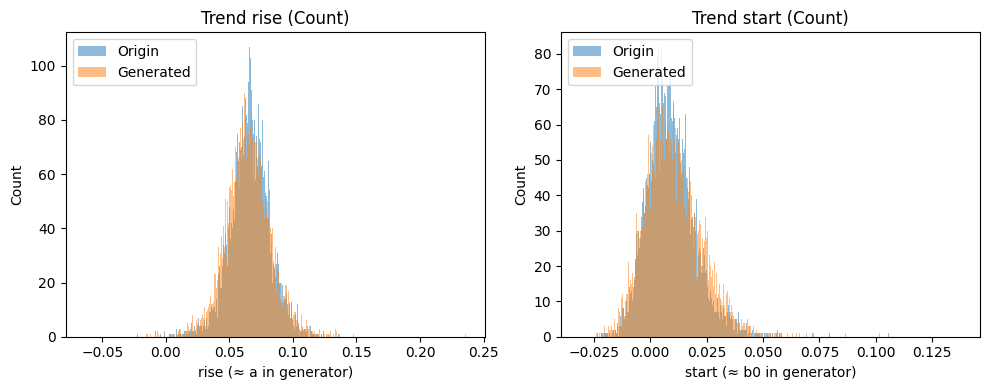

[keep_ratio] origin mean=0.886, gen mean=0.892


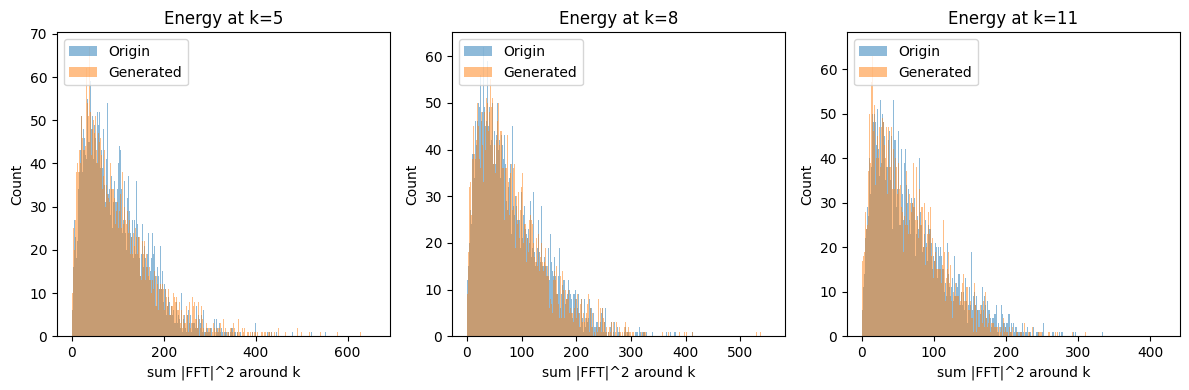

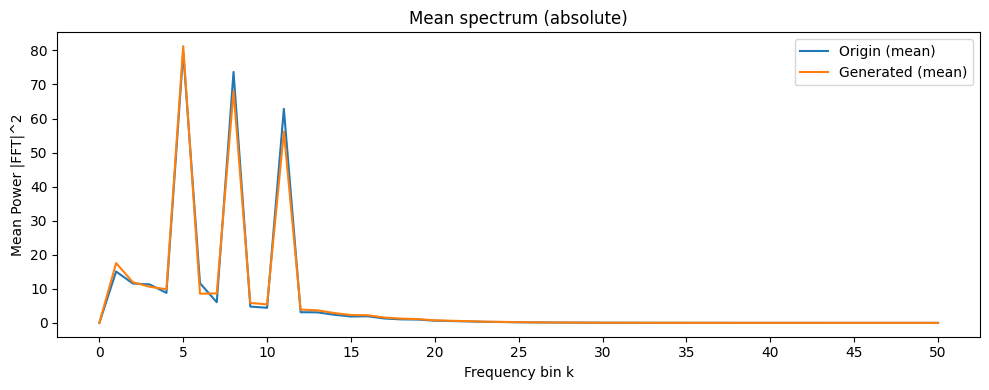

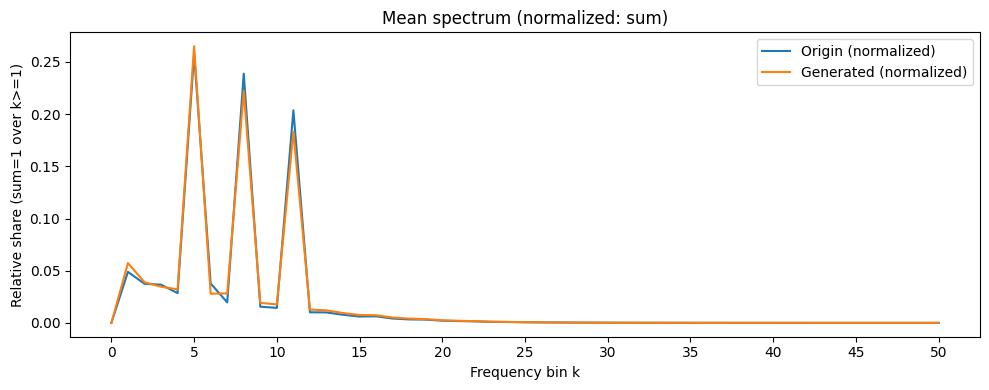

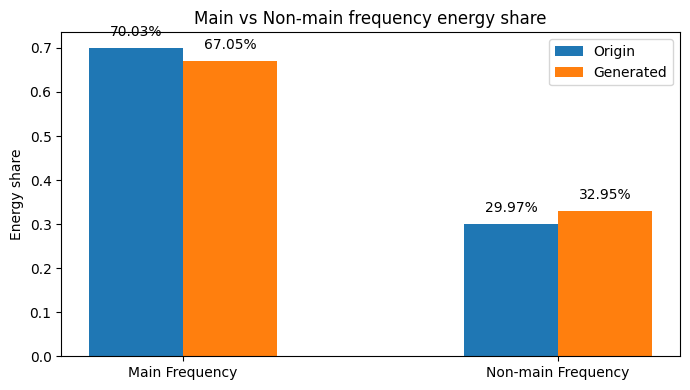

In [13]:
out = plot_trend_global_params_count(
    origin_data=ori,
    generated_data=gen,
    u_global=u_global,
    season_ks=(5, 8, 11),
    event_radius = 8,
    bins=1000,
    logy=False
)

out = plot_k_energy_count(ori, gen, ks=(5,8,11), bins=1000, band=1, logy=False)


out = plot_spectrum(
    ori, gen,
    k_max=50,
    use_power=True,
    remove_dc=True,
    detrend=None,
    logy_abs=False,
    norm_mode="sum",
    main_ks=(5, 8, 11)
)

# 结论：  (1) 时域和频域上都出现长尾收敛, 细节的trend和seasonality也是。(2) 更加偏向于主流模式（主频）。

## extreme detection

### 超过u_global的极值分析

In [14]:
def extract_events_over_threshold(X, u, merge_gap=0, min_width=1):
    """
    Return exactly:
      peak_abs: (E,) absolute peak value per detected event
      widths:   (E,) event width (#points) per detected event
      cnt:      (N,) number of detected events per series

    X: (N,L,1) or (N,L)
    u: threshold
    merge_gap: merge segments whose gap <= merge_gap
    min_width: drop events with width < min_width
    """
    X = np.asarray(X)
    if X.ndim == 3:
        assert X.shape[-1] == 1
        x = X[:, :, 0]
    elif X.ndim == 2:
        x = X
    else:
        raise ValueError("X must have shape (N,L,1) or (N,L)")

    x = x.astype(np.float64)
    N, L = x.shape
    u = float(u)
    merge_gap = int(merge_gap)
    min_width = int(min_width)

    mask = x > u
    peak_list = []
    width_list = []
    cnt = np.zeros((N,), dtype=np.int32)

    for i in range(N):
        m = mask[i]
        if not np.any(m):
            continue

        idx = np.flatnonzero(m)  # sorted indices where x>u

        # build contiguous segments
        segs = []
        s = int(idx[0])
        prev = int(idx[0])
        for t in idx[1:]:
            t = int(t)
            if t == prev + 1:
                prev = t
            else:
                segs.append([s, prev])
                s = t
                prev = t
        segs.append([s, prev])

        # merge segments with small gaps
        if merge_gap > 0 and len(segs) > 1:
            merged = [segs[0]]
            for a, b in segs[1:]:
                last = merged[-1]
                gap = a - last[1] - 1
                if gap <= merge_gap:
                    last[1] = b
                else:
                    merged.append([a, b])
            segs = merged

        # filter + stats
        for l, r in segs:
            w = int(r - l + 1)
            if w < min_width:
                continue
            seg = x[i, l:r+1]
            peak = float(np.max(seg))
            peak_list.append(abs(peak))     # peak_abs (single-sided -> same as peak)
            width_list.append(w)
            cnt[i] += 1

    peak_abs = np.asarray(peak_list, dtype=np.float64)
    widths = np.asarray(width_list, dtype=np.int32)
    return peak_abs, widths, cnt


def plot_extreme_distributions(ori, gen, u_global, bins_amp=50, merge_gap=0, min_width=1):
    """
    ori/gen: (N,L,1) or (N,L)
    - amplitude uses absolute peak value (peak_abs)
    - amplitude & width use shared bins, NOT normalized
    - count per series uses side-by-side bar chart
    - extra bar chart: total number of detected events (ori vs gen) + annotate numbers
    """
    ori_peak, ori_w, ori_cnt = extract_events_over_threshold(ori, u_global, merge_gap=merge_gap, min_width=min_width)
    gen_peak, gen_w, gen_cnt = extract_events_over_threshold(gen, u_global, merge_gap=merge_gap, min_width=min_width)

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    # -------------------------
    # (1) Peak amplitude (absolute peak) histogram, shared bins, not normalized
    # -------------------------
    all_peak = np.concatenate([ori_peak, gen_peak], axis=0) if (ori_peak.size + gen_peak.size) > 0 else np.array([u_global, u_global+1e-6], dtype=np.float32)
    pmin = float(np.min(all_peak))
    pmax = float(np.max(all_peak))
    if pmax <= pmin:
        pmax = pmin + 1e-6
    amp_bins = np.linspace(pmin, pmax, int(bins_amp) + 1)

    axes[0,0].hist(ori_peak, bins=amp_bins, alpha=0.6, label="ori")
    axes[0,0].hist(gen_peak, bins=amp_bins, alpha=0.6, label="gen")
    axes[0,0].axvline(float(u_global), linestyle="--")
    axes[0,0].set_title("Event peak amplitude (absolute)")
    axes[0,0].set_xlabel("peak_abs")
    axes[0,0].set_ylabel("count")
    axes[0,0].set_xlim(0,1.5)
    axes[0,0].legend()

    # -------------------------
    # (2) Event width histogram (integer bins), shared bins, not normalized
    # -------------------------
    wmax = 1
    if ori_w.size > 0:
        wmax = max(wmax, int(np.max(ori_w)))
    if gen_w.size > 0:
        wmax = max(wmax, int(np.max(gen_w)))
    width_bins = np.arange(0.5, wmax + 1.5, 1.0)

    axes[0,1].hist(ori_w, bins=width_bins, alpha=0.6, label="ori")
    axes[0,1].hist(gen_w, bins=width_bins, alpha=0.6, label="gen")
    axes[0,1].set_title("Event width distribution")
    axes[0,1].set_xlabel("width (#points)")
    axes[0,1].set_ylabel("count")
    axes[0,1].set_xticks(np.arange(1, wmax + 1))
    axes[0,1].legend()

    # -------------------------
    # (3) Event count per series: bar chart (side-by-side)
    # -------------------------
    cmax = 0
    if ori_cnt.size > 0:
        cmax = max(cmax, int(np.max(ori_cnt)))
    if gen_cnt.size > 0:
        cmax = max(cmax, int(np.max(gen_cnt)))
    ks = np.arange(0, cmax + 1, dtype=np.int32)

    ori_hist = np.array([(ori_cnt == k).sum() for k in ks], dtype=np.int32)
    gen_hist = np.array([(gen_cnt == k).sum() for k in ks], dtype=np.int32)

    bar_w = 0.38
    axes[1,0].bar(ks - bar_w/2, ori_hist, width=bar_w, label="ori")
    axes[1,0].bar(ks + bar_w/2, gen_hist, width=bar_w, label="gen")
    axes[1,0].set_title("Event count per series")
    axes[1,0].set_xlabel("#events in a series")
    axes[1,0].set_ylabel("#series")
    axes[1,0].set_xticks(ks)
    axes[1,0].legend()

    # -------------------------
    # (4) Total #events: two bars + annotate numbers
    # -------------------------
    total_ori_events = int(ori_peak.size)  # one peak per detected event
    total_gen_events = int(gen_peak.size)

    xs = np.array([0, 1], dtype=np.int32)
    totals = np.array([total_ori_events, total_gen_events], dtype=np.int32)

    axes[1,1].bar(xs, totals)
    axes[1,1].set_title("Total #detected events")
    axes[1,1].set_xlabel("")
    axes[1,1].set_ylabel("#events")
    axes[1,1].set_ylim(0,23000)
    axes[1,1].set_xticks(xs)
    axes[1,1].set_xticklabels(["ori", "gen"])

    # annotate numbers on top of bars
    ymax = max(1, int(totals.max()))
    for x, v in zip(xs, totals):
        axes[1,1].text(float(x), float(v) + 0.02 * ymax, f"{int(v)}",
                     ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

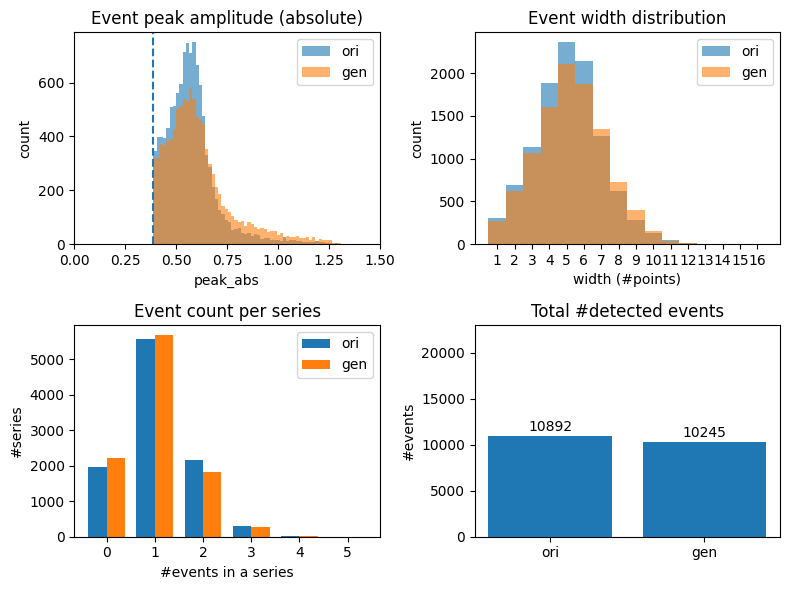

In [15]:
u_global = 0.3880
plot_extreme_distributions(
    ori=ori,
    gen=gen,
    u_global=u_global,
    bins_amp=60,     # 幅度(绝对峰值)直方图的bin数
    merge_gap=1,     # 建议先用1，防止一个 spike 被阈值切成两段
    min_width=1      # 先不滤，后面需要再调大
)

### Block Maxima 分析 GEV分析

In [27]:
def _to_2d(X):
    X = np.asarray(X)
    if X.ndim == 3:
        X = X[:, :, 0]  # (N,L,1)->(N,L)
    if X.ndim != 2:
        raise ValueError(f"X must be (N,L) or (N,L,1), got {X.shape}")
    return X.astype(np.float32)

def extract_topk_per_series(X, top=2):
    """
    X: (N,L) or (N,L,1)
    Return:
      topk_flat: (N*top,) containing top-k values per series (descending within each series).
    """
    X = _to_2d(X)
    N, L = X.shape
    top = int(top)
    if top <= 0:
        raise ValueError("top must be >= 1")
    if L < top:
        raise ValueError(f"Sequence length L={L} is smaller than top={top}")

    # get top-k (unordered), then sort descending
    topk = np.partition(X, kth=-top, axis=1)[:, -top:]   # (N,top)
    topk = np.sort(topk, axis=1)[:, ::-1]                # descending
    return topk.reshape(-1).astype(np.float64)           # (N*top,)

def plot_topk_hist_with_gev_overlay(ori, gen, top=2, bins=50,
                                   title=None):
    """
    - Extract top-k per series from ori and gen
    - Plot two histograms on same axes with SAME bins, counts (no density)
    - Fit GEV separately to ori and gen samples and overlay scaled PDF curves
    """
    ori_vals = extract_topk_per_series(ori, top=top)
    gen_vals = extract_topk_per_series(gen, top=top)

    ori_vals = ori_vals[np.isfinite(ori_vals)]
    gen_vals = gen_vals[np.isfinite(gen_vals)]
    if ori_vals.size < 10 or gen_vals.size < 10:
        raise ValueError(f"Too few samples: ori={ori_vals.size}, gen={gen_vals.size}")

    # shared equal-width bins from combined range
    allv = np.concatenate([ori_vals, gen_vals], axis=0)
    vmin, vmax = float(allv.min()), float(allv.max())
    if vmax <= vmin:
        vmax = vmin + 1e-6
    edges = np.linspace(vmin, vmax, int(bins) + 1)
    bin_w = float(edges[1] - edges[0])

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(ori_vals, bins=edges, alpha=0.55, label=f"ori top-{top} (n={ori_vals.size})")
    ax.hist(gen_vals, bins=edges, alpha=0.55, label=f"gen top-{top} (n={gen_vals.size})")
    ax.set_xlabel(f"value (top-{top} per series)")
    ax.set_ylabel("count")
    ax.set_title(title or f"ORI vs GEN: top-{top} over full length + GEV fits")

    # GEV fit & overlay (scaled to counts)
    try:
        from scipy.stats import genextreme
    except Exception as e:
        raise ImportError("Need scipy for GEV fitting: pip install scipy") from e

    c_o, loc_o, scale_o = genextreme.fit(ori_vals)
    c_g, loc_g, scale_g = genextreme.fit(gen_vals)

    grid = np.linspace(vmin, vmax, 600)
    pdf_o = genextreme.pdf(grid, c_o, loc=loc_o, scale=scale_o)
    pdf_g = genextreme.pdf(grid, c_g, loc=loc_g, scale=scale_g)

    # scale pdf -> expected counts per bin
    y_o = pdf_o * bin_w * float(ori_vals.size)
    y_g = pdf_g * bin_w * float(gen_vals.size)

    ax.plot(grid, y_o, linewidth=2.0,
            label=f"ORI GEV: c={c_o:.3g}, loc={loc_o:.3g}, scale={scale_o:.3g} (xi={-c_o:.3g})")
    ax.plot(grid, y_g, linewidth=2.0,
            label=f"GEN GEV: c={c_g:.3g}, loc={loc_g:.3g}, scale={scale_g:.3g} (xi={-c_g:.3g})")

    ax.legend()
    plt.tight_layout()
    plt.show()

    print(f"[ORI] top={top} | xi={-float(c_o):.6g}, loc={float(loc_o):.6g}, scale={float(scale_o):.6g}")
    print(f"[GEN] top={top} | xi={-float(c_g):.6g}, loc={float(loc_g):.6g}, scale={float(scale_g):.6g}")


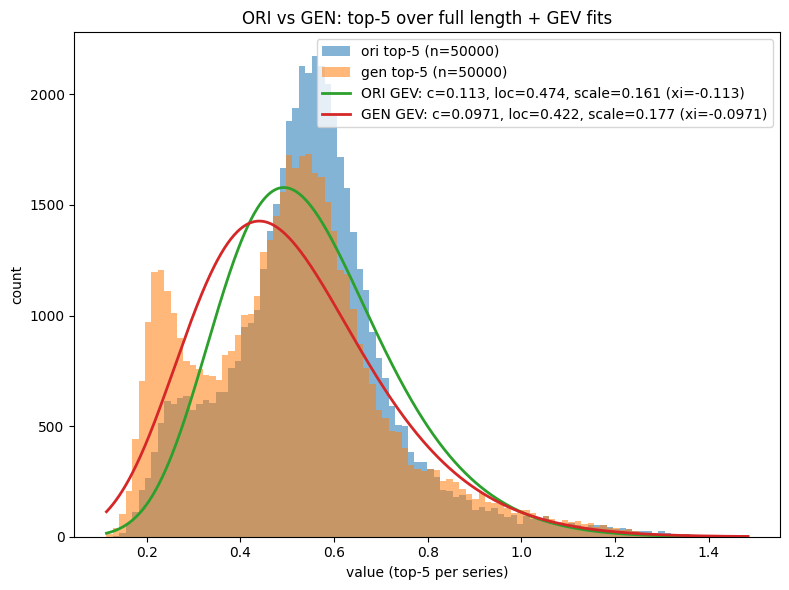

[ORI] top=5 | xi=-0.11273, loc=0.473795, scale=0.160656
[GEN] top=5 | xi=-0.0971239, loc=0.422307, scale=0.177433


In [28]:
plot_topk_hist_with_gev_overlay(ori, gen, top=5, bins=100)

### value exceedance analysis GPD分析

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def _to_2d(X):
    X = np.asarray(X)
    if X.ndim == 3:
        X = X[:, :, 0]
    if X.ndim != 2:
        raise ValueError(f"X must be (N,L) or (N,L,1), got {X.shape}")
    return X.astype(np.float32)

def extract_exceedances(X, u_global):
    """
    Return all point-wise exceedances y = x - u_global for x > u_global.
    """
    X = _to_2d(X)
    u = float(u_global)
    y = X - u
    y = y[y > 0.0].astype(np.float64)
    return y

def plot_exceedance_hist_with_gpd_overlay(ori, gen, u_global, bins=60, title=None):
    """
    Same bins, counts (no density), overlay two GPD pdf curves scaled to counts.
    Fit GPD on exceedances (y>0), with loc fixed to 0.
    """
    y_ori = extract_exceedances(ori, u_global)
    y_gen = extract_exceedances(gen, u_global)

    if y_ori.size < 20 or y_gen.size < 20:
        raise ValueError(f"Too few exceedances: ori={y_ori.size}, gen={y_gen.size}. "
                         f"Maybe gen/ori rarely cross u_global, or u_global is too high.")

    # shared equal-width bins from combined exceedance range
    allv = np.concatenate([y_ori, y_gen], axis=0)
    vmin, vmax = float(allv.min()), float(allv.max())
    if vmax <= vmin:
        vmax = vmin + 1e-6
    edges = np.linspace(vmin, vmax, int(bins) + 1)
    bin_w = float(edges[1] - edges[0])

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(y_ori, bins=edges, alpha=0.55, label=f"ori exceedance (n={y_ori.size})")
    ax.hist(y_gen, bins=edges, alpha=0.55, label=f"gen exceedance (n={y_gen.size})")
    ax.set_xlabel("exceedance y = x - u_global (y>0)")
    ax.set_ylabel("count")
    ax.set_title(title or "ORI vs GEN: exceedance over u_global + GPD fits")

    # fit GPD and overlay (scaled to counts)
    try:
        from scipy.stats import genpareto
    except Exception as e:
        raise ImportError("Need scipy for GPD fitting: pip install scipy") from e

    # SciPy genpareto: shape=c is xi (EVT notation), support y>=0 when loc=0 and c >= -scale/max(y)
    # Fix loc=0 for exceedance modeling
    c_o, loc_o, scale_o = genpareto.fit(y_ori, floc=0.0)
    c_g, loc_g, scale_g = genpareto.fit(y_gen, floc=0.0)

    grid = np.linspace(vmin, vmax, 600)
    pdf_o = genpareto.pdf(grid, c_o, loc=0.0, scale=scale_o)
    pdf_g = genpareto.pdf(grid, c_g, loc=0.0, scale=scale_g)

    # scale pdf -> expected counts per bin
    ycurve_o = pdf_o * bin_w * float(y_ori.size)
    ycurve_g = pdf_g * bin_w * float(y_gen.size)

    ax.plot(grid, ycurve_o, linewidth=2.0,
            label=f"ORI GPD: xi={c_o:.3g}, scale={scale_o:.3g}")
    ax.plot(grid, ycurve_g, linewidth=2.0,
            label=f"GEN GPD: xi={c_g:.3g}, scale={scale_g:.3g}")

    ax.legend()
    plt.tight_layout()
    plt.show()

    # print quick stats
    def qsum(a):
        qs = np.quantile(a, [0.5, 0.9, 0.95, 0.99, 1.0])
        return f"p50={qs[0]:.4g}, p90={qs[1]:.4g}, p95={qs[2]:.4g}, p99={qs[3]:.4g}, max={qs[4]:.4g}"

    N_ori, L_ori = _to_2d(ori).shape
    N_gen, L_gen = _to_2d(gen).shape
    rate_ori = y_ori.size / float(N_ori * L_ori)
    rate_gen = y_gen.size / float(N_gen * L_gen)

    print(f"[Exceed rate] ori: {y_ori.size}/{N_ori*L_ori} = {rate_ori:.6g}")
    print(f"[Exceed rate] gen: {y_gen.size}/{N_gen*L_gen} = {rate_gen:.6g}")
    print(f"[Exceed summary] ori: {qsum(y_ori)}")
    print(f"[Exceed summary] gen: {qsum(y_gen)}")
    print(f"[GPD fit] ori: xi={float(c_o):.6g}, scale={float(scale_o):.6g} (loc fixed 0)")
    print(f"[GPD fit] gen: xi={float(c_g):.6g}, scale={float(scale_g):.6g} (loc fixed 0)")

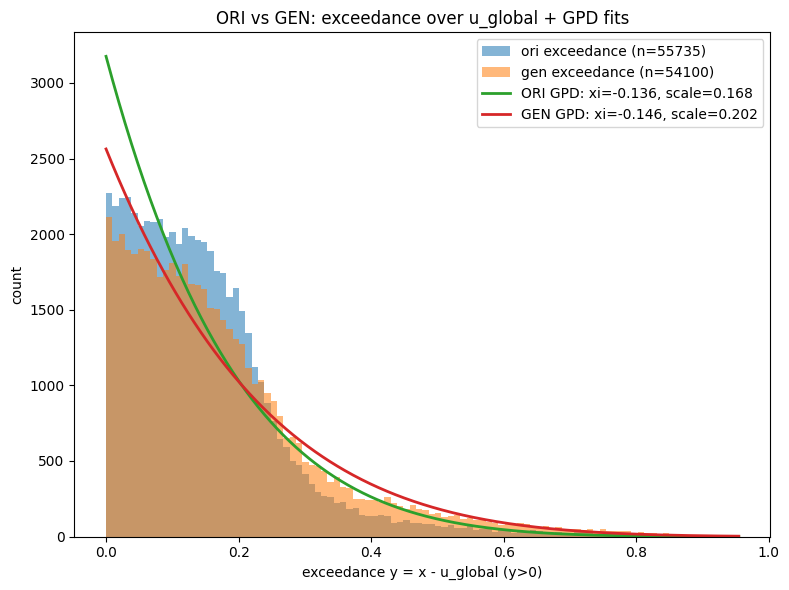

[Exceed rate] ori: 55735/2000000 = 0.0278675
[Exceed rate] gen: 54100/2000000 = 0.02705
[Exceed summary] ori: p50=0.1264, p90=0.2839, p95=0.3716, p99=0.6242, max=0.9546
[Exceed summary] gen: p50=0.1401, p90=0.3733, p95=0.492, p99=0.72, max=0.9192
[GPD fit] ori: xi=-0.136424, scale=0.167552 (loc fixed 0)
[GPD fit] gen: xi=-0.145837, scale=0.201511 (loc fixed 0)


In [19]:
plot_exceedance_hist_with_gpd_overlay(ori, gen, u_global, bins=100)

In [20]:
def _to_2d(X):
    X = np.asarray(X)
    if X.ndim == 3:
        X = X[:, :, 0]
    if X.ndim != 2:
        raise ValueError(f"X must be (N,L) or (N,L,1), got {X.shape}")
    return X.astype(np.float32)

def extract_event_level_exceedances(X, u_global, merge_gap=0, min_width=1):
    """
    Event = contiguous segment where x > u_global (optionally merged by small gaps).
    For each event, take one sample: y_event = max(x - u_global) over that segment.

    Returns:
      y_event: (E,) event-level exceedances
      counts:  (N,) number of events per series
    """
    X = _to_2d(X)
    N, L = X.shape
    u = float(u_global)

    y_events = []
    counts = np.zeros((N,), dtype=np.int32)

    for i in range(N):
        x = X[i]
        mask = x > u
        idx = np.flatnonzero(mask)
        if idx.size == 0:
            continue

        # split into raw segments
        split_pos = np.flatnonzero(np.diff(idx) > 1)
        starts = np.concatenate(([idx[0]], idx[split_pos + 1])).astype(np.int32)
        ends   = np.concatenate((idx[split_pos], [idx[-1]])).astype(np.int32)

        # merge small gaps if needed
        if merge_gap > 0 and len(starts) > 1:
            m_starts = [int(starts[0])]
            m_ends   = [int(ends[0])]
            for s, e in zip(starts[1:], ends[1:]):
                s = int(s); e = int(e)
                if s - m_ends[-1] - 1 <= int(merge_gap):
                    m_ends[-1] = e
                else:
                    m_starts.append(s)
                    m_ends.append(e)
            starts = np.asarray(m_starts, dtype=np.int32)
            ends   = np.asarray(m_ends, dtype=np.int32)

        c = 0
        for s, e in zip(starts, ends):
            w = int(e - s + 1)
            if w < int(min_width):
                continue
            seg = x[s:e+1]
            y = float(np.max(seg) - u)  # event-level max exceedance
            if y > 0:
                y_events.append(y)
                c += 1

        counts[i] = c

    return np.asarray(y_events, dtype=np.float64), counts

def plot_event_exceedance_hist_with_gpd_overlay(ori, gen, u_global, bins=60,
                                               merge_gap=0, min_width=1,
                                               title=None):
    """
    Same bins, counts (no density), overlay two GPD pdf curves scaled to counts.
    Fit GPD on event-level exceedances, with loc fixed to 0.
    """
    y_ori, cnt_ori = extract_event_level_exceedances(ori, u_global, merge_gap=merge_gap, min_width=min_width)
    y_gen, cnt_gen = extract_event_level_exceedances(gen, u_global, merge_gap=merge_gap, min_width=min_width)

    if y_ori.size < 20 or y_gen.size < 20:
        raise ValueError(f"Too few event-level exceedances: ori={y_ori.size}, gen={y_gen.size}. "
                         f"Try smaller u_global or check generation quality.")

    # shared bins
    allv = np.concatenate([y_ori, y_gen], axis=0)
    vmin, vmax = float(allv.min()), float(allv.max())
    if vmax <= vmin:
        vmax = vmin + 1e-6
    edges = np.linspace(vmin, vmax, int(bins) + 1)
    bin_w = float(edges[1] - edges[0])

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(y_ori, bins=edges, alpha=0.55, label=f"ori event-exceed (n={y_ori.size})")
    ax.hist(y_gen, bins=edges, alpha=0.55, label=f"gen event-exceed (n={y_gen.size})")
    ax.set_xlabel("event exceedance y_event = max(x-u_global) in each exceed segment")
    ax.set_ylabel("count")
    ax.set_title(title or "ORI vs GEN: event-level exceedance over u_global + GPD fits")

    # fit GPD & overlay
    try:
        from scipy.stats import genpareto
    except Exception as e:
        raise ImportError("Need scipy for GPD fitting: pip install scipy") from e

    c_o, _, scale_o = genpareto.fit(y_ori, floc=0.0)
    c_g, _, scale_g = genpareto.fit(y_gen, floc=0.0)

    grid = np.linspace(vmin, vmax, 600)
    pdf_o = genpareto.pdf(grid, c_o, loc=0.0, scale=scale_o)
    pdf_g = genpareto.pdf(grid, c_g, loc=0.0, scale=scale_g)

    ycurve_o = pdf_o * bin_w * float(y_ori.size)
    ycurve_g = pdf_g * bin_w * float(y_gen.size)

    ax.plot(grid, ycurve_o, linewidth=2.0,
            label=f"ORI GPD: xi={c_o:.3g}, scale={scale_o:.3g}")
    ax.plot(grid, ycurve_g, linewidth=2.0,
            label=f"GEN GPD: xi={c_g:.3g}, scale={scale_g:.3g}")

    ax.legend()
    plt.tight_layout()
    plt.show()

    # print summaries
    def qsum(a):
        qs = np.quantile(a, [0.5, 0.9, 0.95, 0.99, 1.0])
        return f"p50={qs[0]:.4g}, p90={qs[1]:.4g}, p95={qs[2]:.4g}, p99={qs[3]:.4g}, max={qs[4]:.4g}"

    N_ori, L_ori = _to_2d(ori).shape
    N_gen, L_gen = _to_2d(gen).shape

    print(f"[#events] ori total={int(y_ori.size)}, per-series mean={cnt_ori.mean():.4g}, max={cnt_ori.max() if cnt_ori.size else 0}")
    print(f"[#events] gen total={int(y_gen.size)}, per-series mean={cnt_gen.mean():.4g}, max={cnt_gen.max() if cnt_gen.size else 0}")
    print(f"[event exceed summary] ori: {qsum(y_ori)}")
    print(f"[event exceed summary] gen: {qsum(y_gen)}")
    print(f"[GPD fit] ori: xi={float(c_o):.6g}, scale={float(scale_o):.6g} (loc fixed 0)")
    print(f"[GPD fit] gen: xi={float(c_g):.6g}, scale={float(scale_g):.6g} (loc fixed 0)")

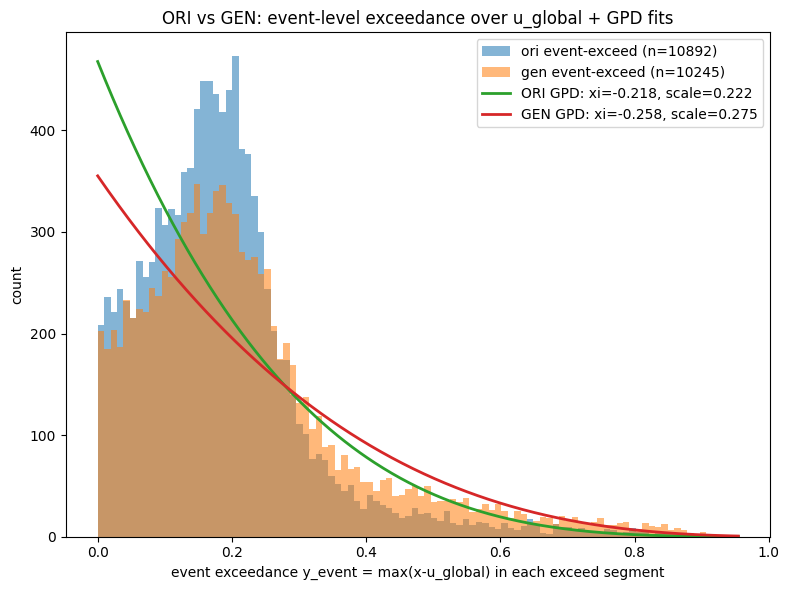

[#events] ori total=10892, per-series mean=1.089, max=5
[#events] gen total=10245, per-series mean=1.024, max=4
[event exceed summary] ori: p50=0.1714, p90=0.3184, p95=0.4198, p99=0.6918, max=0.9546
[event exceed summary] gen: p50=0.1876, p90=0.4423, p95=0.5716, p99=0.7861, max=0.9192
[GPD fit] ori: xi=-0.217613, scale=0.222219 (loc fixed 0)
[GPD fit] gen: xi=-0.258455, scale=0.27527 (loc fixed 0)


In [21]:
plot_event_exceedance_hist_with_gpd_overlay(ori, gen, u_global, bins=100, merge_gap=1, min_width=1)

## （1）最极端的那部分极值幅度并没有被削弱，而是占主流的中小极值幅度被削弱了。（2）极值生成过程中的多样性被严重破坏，极值的位置，形状，幅度都向着均值靠拢。

In [22]:
def _to_1d(x):
    """Accept (N,T,1)/(N,T)/(N,) etc. Return flattened 1D float array."""
    x = np.asarray(x)
    if x.ndim >= 3 and x.shape[-1] == 1:
        x = x[..., 0]
    return x.reshape(-1).astype(np.float64)

def quick_tail_stats(ori, gen, u=0.25, name_ori="ori", name_gen="gen"):
    """
    Print basic distribution stats for ori and gen on the same threshold u.
    Stats:
      - mean/std
      - q95/q99
      - exceedance rate P(x > u)
      - exceedance count
    """
    for name, data in [(name_ori, ori), (name_gen, gen)]:
        flat = _to_1d(data)
        mean = float(np.mean(flat))
        std = float(np.std(flat, ddof=0))
        q95, q99 = np.quantile(flat, [0.95, 0.99])
        ex_rate = float(np.mean(flat > u))
        ex_cnt = int(np.sum(flat > u))
        n = flat.size

        print(f"===== {name} =====")
        print(f"N = {n}")
        print(f"mean = {mean:.6f}, std = {std:.6f}")
        print(f"q95  = {q95:.6f}, q99 = {q99:.6f}")
        print(f"P(x > {u}) = {ex_rate:.6f}  (count = {ex_cnt})")
        print()


In [23]:
quick_tail_stats(ori,gen)

===== ori =====
N = 2000000
mean = 0.058946, std = 0.124956
q95  = 0.259031, q99 = 0.553350
P(x > 0.25) = 0.052815  (count = 105630)

===== gen =====
N = 2000000
mean = 0.058670, std = 0.124755
q95  = 0.240360, q99 = 0.572031
P(x > 0.25) = 0.047349  (count = 94697)

